In [1]:
!pip install jupyter pandas seaborn pillow networkx nltk
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.16.0
    Uninstalling jupyter-server-1.16.0:
      Successfully uninstalled jupyter-server-1.16.0
ERROR: Could not open requirements file: [Errno 2] No such file or director

In [2]:
from time import time
from pathlib import Path
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json
import re
import unicodedata
from collections import Counter

In [3]:
import re
import os

from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk
import matplotlib.patches as mpatches


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [4]:
from google.colab import files
uploaded = files.upload()

Saving us_2020_election_speeches.csv to us_2020_election_speeches.csv


In [5]:
# Subir el .csv con el nombre "us_2020_election_speeches"
df = pd.read_csv('us_2020_election_speeches.csv')
df.tail(1)

,speaker,title,text,date,location,type
268,Democratic Candidates,January Iowa Democratic Debate Transcript,"Wolf Blitzer: (00:00)\nAll right, so let’s beg...","Jan 15, 2020","Des Moines, Iowa",Debate


In [6]:
#Copiar el df para modificarlo
df_expandidos = df.copy()

#Convertir los textos de la columna speaker en listas, separando por comas
df_expandidos['speaker'] = df_expandidos['speaker'].str.split(',')

#Crear una fila nueva para cada elemento de la lista en la columna speaker
df_expandidos = df_expandidos.explode('speaker')

#Eliminar espacios al inicio y final
df_expandidos['speaker'] = df_expandidos['speaker'].str.strip()

#Contar la cantidad de veces que aparece el speaker y ordenar los 3 primeros
conteo_expandidos = df_expandidos['speaker'].value_counts()
top3_speakers = conteo_expandidos.head(3)
df_top3 = df_expandidos[df_expandidos['speaker'].isin(top3_speakers.index)].copy()
top3_speakers

,count
speaker,
Joe Biden,81
Donald Trump,54
Mike Pence,20


In [7]:
# Función para extraer solo el texto del orador principal
def extraer_texto_speaker(texto_completo, nombre_objetivo):
    if not isinstance(texto_completo, str) or not texto_completo:
        return ''

    patron = re.compile(r'([^\n:]+): \(\d{2}:\d{2}\)\n(.*?)(?=\n[^\n:]+: \(\d{2}:\d{2}\)|$)', re.DOTALL)
    fragmentos_filtrados = []
    for match in patron.finditer(texto_completo):
        speaker, contenido = match.groups()
        speaker = speaker.strip()
        if speaker == nombre_objetivo:
            fragmentos_filtrados.append(contenido.strip())

    return '\n'.join(fragmentos_filtrados)

# Función para limpieza de texto
def limpiar_texto_robusto(texto):
    if not isinstance(texto, str):
        return ''

    # Convertir a minúsculas
    texto = texto.lower()

    # Normalizar caracteres
    texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')

    # Eliminar puntuación y caracteres especiales
    texto = re.sub(r'[^a-z\s]', ' ', texto)

    # Eliminar múltiples espacios
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

# Función para aplicar las operaciones de filtrado y limpieza a cada fila del DataFrame
def obtener_texto_filtrado(row):
    texto = row['text']
    speaker = row['speaker']

    if not texto or not speaker:
        return ''  # Si no hay texto o orador, devolver cadena vacía

    # Aplicar extracción y limpieza
    texto_filtrado = extraer_texto_speaker(texto, speaker)
    texto_limpio = limpiar_texto_robusto(texto_filtrado)

    return texto_limpio

# Aplicar la función a todas las filas del DataFrame y crear la columna 'clean_text'
df_top3['clean_text'] = df_top3.apply(obtener_texto_filtrado, axis=1)



In [9]:
# Particiona el dataframe
train, test = train_test_split(df_top3, test_size=0.3, stratify=df_top3['speaker'], random_state=42)


# Muestra la cantidad de discursos por candidato en cada conjunto
print("Distribución en TRAIN:")
print(train['speaker'].value_counts())
print("\nDistribución en TEST:")
print(test['speaker'].value_counts())


Distribución en TRAIN:
speaker
Joe Biden       56
Donald Trump    38
Mike Pence      14
Name: count, dtype: int64

Distribución en TEST:
speaker
Joe Biden       25
Donald Trump    16
Mike Pence       6
Name: count, dtype: int64


In [10]:
# Suponiendo que los textos ya están limpios en train['clean_text']

# Unir todos los textos del conjunto de entrenamiento en uno solo
texto_entrenamiento = " ".join(train['clean_text'])

# Dividir por espacios para obtener las palabras
palabras = texto_entrenamiento.split()

# Contar la cantidad total
cantidad_total_palabras = len(palabras)

print(f"Cantidad total de palabras en el conjunto de entrenamiento: {cantidad_total_palabras}")

Cantidad total de palabras en el conjunto de entrenamiento: 446487


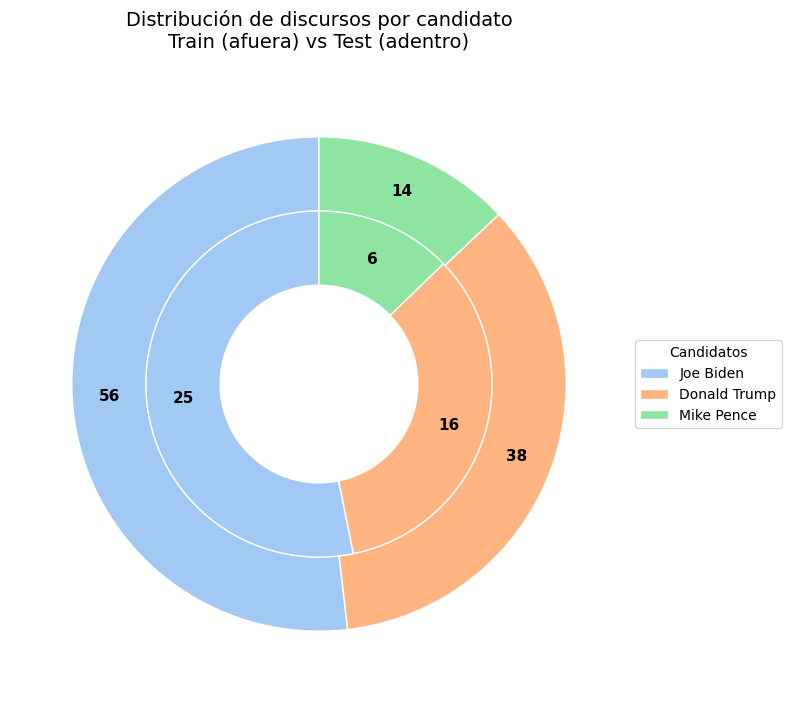

In [12]:
# Datos
train_counts = train['speaker'].value_counts()
test_counts = test['speaker'].value_counts()
labels = train_counts.index.tolist()

# Colores pastel consistentes
colors = ['#A1C9F4', '#FFB482', '#8DE5A1']

# Crear figura
fig, ax = plt.subplots(figsize=(8, 8))

# Anillo exterior - TRAIN
wedges1, _ = ax.pie(
    train_counts,
    radius=1,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='white')
)

# Anillo interior - TEST
wedges2, _ = ax.pie(
    test_counts,
    radius=0.7,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='white')
)

# Función para agregar los números dentro de los anillos
def add_labels(wedges, counts, inner_radius):
    angles = [w.theta1 + (w.theta2 - w.theta1) / 2 for w in wedges]
    for i, angle in enumerate(angles):
        r = inner_radius + 0.15  # coloca el texto dentro del anillo
        x = r * np.cos(np.deg2rad(angle))
        y = r * np.sin(np.deg2rad(angle))
        ax.text(x, y, str(counts[i]), ha='center', va='center', fontsize=11, weight='bold')

# Etiquetas NUMÉRICAS dentro de los anillos
add_labels(wedges1, train_counts.values, inner_radius=0.70)
add_labels(wedges2, test_counts.values, inner_radius=0.40)

# Leyenda
ax.legend(wedges1, labels, title="Candidatos", loc="center left", bbox_to_anchor=(1, 0.5))

# Título
ax.set(aspect="equal")
plt.title("Distribución de discursos por candidato\nTrain (afuera) vs Test (adentro)", fontsize=14, pad=20)

plt.tight_layout()
plt.show()




In [14]:
# Creamos el vectorizador
vectorizer = CountVectorizer()

# Aplicamos solo al conjunto de entrenamiento
X_train_counts = vectorizer.fit_transform(train['clean_text'])

# Convertimos a DataFrame para visualizar
df_bow = pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Mostramos parte de la matriz
print("Matriz Bag of Words (primeras filas):")
print(df_bow.head(10))


Matriz Bag of Words (primeras filas):
   aa  aaa  aapi  ab  abandon  abandoned  abbott  abc  abdelaziz  abducted  \
0   0    0     0   0        0          0       0    1          0         0   
1   0    0     0   0        0          0       0    0          0         0   
2   0    0     0   0        0          0       0    0          0         0   
3   0    0     0   0        0          0       0    0          0         0   
4   0    0     0   0        0          0       0    0          0         0   
5   0    0     0   0        0          0       0    0          0         0   
6   0    0     0   0        0          0       0    0          0         0   
7   0    0     0   0        0          1       0    0          0         0   
8   0    0     0   0        0          0       0    0          0         0   
9   0    0     0   0        0          0       0    0          0         0   

   ...  zigzag  zip  zo  zoes  zone  zones  zoning  zoom  zucker  zuckerberg  
0  ...       0    0   0 

In [15]:
# Para ver las palabras más frecuentes y despues decidir si quitar las stopwords - SPOILER --> Si
word_freq = np.asarray(X_train_counts.sum(axis=0)).flatten()
top_words = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': word_freq
}).sort_values(by='frequency', ascending=False)

print(f"Cantidad total de palabras únicas en el vocabulario: {len(vectorizer.get_feature_names_out())}")

print("Top 10 palabras más frecuentes:")
print(top_words.head(10))

Cantidad total de palabras únicas en el vocabulario: 11017
Top 10 palabras más frecuentes:
       word  frequency
9830    the      18811
406     and      14070
9969     to      14059
6706     of       8693
10986   you       7735
4884     in       6894
10685    we       6783
9827   that       6688
5222     it       6144
9860   they       4626


In [16]:
print("Tamaño de la matriz:", X_train_counts.shape)
print("Tipo de matriz:", type(X_train_counts))
print("¿Es sparse?", hasattr(X_train_counts, 'toarray'))

total_elementos = X_train_counts.shape[0] * X_train_counts.shape[1] # Total de elementos

# Cantidad de ceros = total - cantidad de elementos distintos de cero
ceros = total_elementos - X_train_counts.count_nonzero()

print("Porcentaje de ceros en la matriz:", round(ceros / total_elementos * 100,1), "%")

Tamaño de la matriz: (108, 11017)
Tipo de matriz: <class 'scipy.sparse._csr.csr_matrix'>
¿Es sparse? True
Porcentaje de ceros en la matriz: 92.6 %


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creamos el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',     # elimina palabras muy comunes (conectores, nexos, etc.)
    use_idf=True,             # aplica penalización IDF
    ngram_range=(1, 2)        # incluye unigramas y bigramas
)

# Ajustamos y transformamos SOLO el conjunto de entrenamiento
X_train_tfidf = tfidf_vectorizer.fit_transform(train['clean_text'])

# Mostramos la forma de la matriz TF-IDF
print("Tamaño de la matriz TF-IDF:", X_train_tfidf.shape)  # (n_docs, n_features)

# Convertimos a DataFrame para ver las columnas (n-gramas)
df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Mostramos las primeras filas
print("Primeras filas de la matriz TF-IDF:")
print(df_tfidf.head())

Tamaño de la matriz TF-IDF: (108, 132246)
Primeras filas de la matriz TF-IDF:
    aa  aa step  aaa  aaa funeral  aapi  aapi folks   ab  ab stoddard  \
0  0.0      0.0  0.0          0.0   0.0         0.0  0.0          0.0   
1  0.0      0.0  0.0          0.0   0.0         0.0  0.0          0.0   
2  0.0      0.0  0.0          0.0   0.0         0.0  0.0          0.0   
3  0.0      0.0  0.0          0.0   0.0         0.0  0.0          0.0   
4  0.0      0.0  0.0          0.0   0.0         0.0  0.0          0.0   

   abandon  abandon fairly  ...    zoning  zoning build  zoning rule  zoom  \
0      0.0             0.0  ...  0.006343      0.006343          0.0   0.0   
1      0.0             0.0  ...  0.000000      0.000000          0.0   0.0   
2      0.0             0.0  ...  0.000000      0.000000          0.0   0.0   
3      0.0             0.0  ...  0.000000      0.000000          0.0   0.0   
4      0.0             0.0  ...  0.000000      0.000000          0.0   0.0   

   zoom leadin

/tmp/ipython-input-20-16330652.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-20-16330652.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


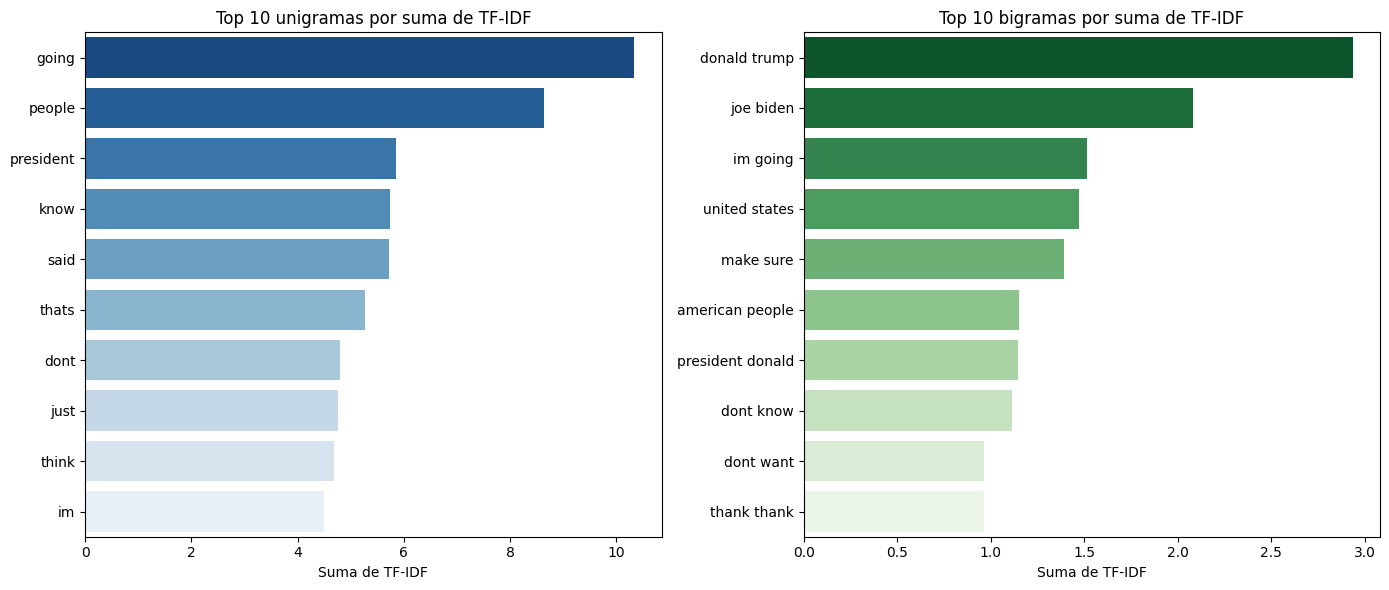

In [20]:
# Extraer nombres de n-gramas y sumar su TF-IDF
features = tfidf_vectorizer.get_feature_names_out()
tfidf_suma = np.asarray(X_train_tfidf.sum(axis=0)).flatten()
df_tfidf_sum = pd.DataFrame({'n_grama': features, 'suma_tfidf': tfidf_suma})

# Separar unigramas y bigramas
df_unigramas = df_tfidf_sum[df_tfidf_sum['n_grama'].apply(lambda x: len(x.split()) == 1)]
df_bigramas = df_tfidf_sum[df_tfidf_sum['n_grama'].apply(lambda x: len(x.split()) == 2)]

# Ordenar y seleccionar los top 10
top_unigramas = df_unigramas.sort_values(by='suma_tfidf', ascending=False).head(10)
top_bigramas = df_bigramas.sort_values(by='suma_tfidf', ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# Unigramas (izquierda)
sns.barplot(
    data=top_unigramas,
    y='n_grama',
    x='suma_tfidf',
    ax=axes[0],
    palette='Blues_r'
)
axes[0].set_title('Top 10 unigramas por suma de TF-IDF')
axes[0].set_xlabel('Suma de TF-IDF')
axes[0].set_ylabel('')

# Bigramas (derecha)
sns.barplot(
    data=top_bigramas,
    y='n_grama',
    x='suma_tfidf',
    ax=axes[1],
    palette='Greens_r'
)
axes[1].set_title('Top 10 bigramas por suma de TF-IDF')
axes[1].set_xlabel('Suma de TF-IDF')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [21]:

# Convertir matriz TF-IDF a DataFrame (ya lo hacías)
df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Redondear los valores para visualización
df_tfidf_round = df_tfidf.round(3)

# Seleccionar las 20 columnas (términos) con mayor suma de TF-IDF
top_terms = df_tfidf.sum(axis=0).sort_values(ascending=False).head(20).index
df_tfidf_top = df_tfidf_round[top_terms]

print("Vista simplificada de la matriz TF-IDF (20 términos más representativos):")
display(df_tfidf_top.head(10))


Vista simplificada de la matriz TF-IDF (20 términos más representativos):


,going,people,president,know,said,thats,dont,just,think,im,great,like,theyre,trump,right,american,country,want,say,got
0,0.183,0.198,0.055,0.154,0.131,0.109,0.141,0.080,0.101,0.058,0.111,0.124,0.131,0.151,0.102,0.045,0.053,0.076,0.056,0.100
1,0.224,0.148,0.030,0.132,0.164,0.088,0.146,0.064,0.053,0.043,0.136,0.076,0.112,0.045,0.068,0.054,0.064,0.110,0.088,0.082
2,0.060,0.060,0.147,0.055,0.047,0.030,0.015,0.070,0.021,0.025,0.005,0.010,0.016,0.141,0.041,0.058,0.067,0.030,0.010,0.005
3,0.063,0.089,0.150,0.037,0.033,0.027,0.022,0.048,0.000,0.026,0.063,0.011,0.017,0.000,0.005,0.050,0.038,0.011,0.044,0.011
4,0.008,0.042,0.043,0.025,0.000,0.068,0.017,0.034,0.009,0.008,0.000,0.043,0.000,0.029,0.026,0.009,0.061,0.068,0.035,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.120,0.104,0.011,0.066,0.046,0.056,0.073,0.072,0.092,0.022,0.125,0.034,0.041,0.012,0.034,0.029,0.091,0.134,0.079,0.088
7,0.105,0.055,0.226,0.087,0.057,0.032,0.012,0.071,0.025,0.031,0.055,0.028,0.013,0.097,0.053,0.125,0.065,0.032,0.024,0.059
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0.104,0.052,0.220,0.068,0.084,0.004,0.016,0.040,0.038,0.028,0.074,0.041,0.000,0.154,0.037,0.136,0.041,0.012,0.021,0.013


In [22]:
# Asegurar que los índices coincidan
import numpy as np

# Creamos un DataFrame con los valores TF-IDF y la clase (orador)
df_tfidf['speaker'] = train['speaker'].values

In [23]:
# Agrupar por orador y sacar el promedio de cada palabra (columna)
tfidf_por_speaker = df_tfidf.groupby('speaker').mean()

In [25]:
# Función para mostrar el top N de palabras por orador
def top_palabras_tfidf(orador, top_n=10):
    print(f"\nTop {top_n} palabras/gramas para: {orador}")
    top = tfidf_por_speaker.loc[orador].sort_values(ascending=False).head(top_n)
    print(top)

oradores = tfidf_por_speaker.index.tolist()
for orador in oradores:
    top_palabras_tfidf(orador, top_n=10)


Top 10 palabras/gramas para: Donald Trump
going     0.111276
people    0.093655
said      0.085384
great     0.083618
dont      0.073776
know      0.071618
right     0.064895
thats     0.060775
theyre    0.058295
want      0.058149
Name: Donald Trump, dtype: float64

Top 10 palabras/gramas para: Joe Biden
going        0.095761
people       0.080427
president    0.061724
im           0.051598
thats        0.049025
make         0.045672
know         0.045114
just         0.043406
think        0.040720
country      0.037143
Name: Joe Biden, dtype: float64

Top 10 palabras/gramas para: Mike Pence
president           0.112188
president donald    0.077866
joe biden           0.076942
american            0.074771
joe                 0.069023
biden               0.064538
years               0.061676
trump               0.061434
america             0.053159
going               0.053154
Name: Mike Pence, dtype: float64


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt

# === Vectorización TF-IDF con filtros ===
vectorizer_filtros = TfidfVectorizer(
    stop_words='english',
    use_idf=True,
    ngram_range=(1, 2)
)

# Entrenar vectorizador con el texto de entrenamiento
X_train_tfidf = vectorizer_filtros.fit_transform(train['clean_text'])

# Transformar texto del conjunto de test con el mismo vectorizador
X_test_tfidf = vectorizer_filtros.transform(test['clean_text'])

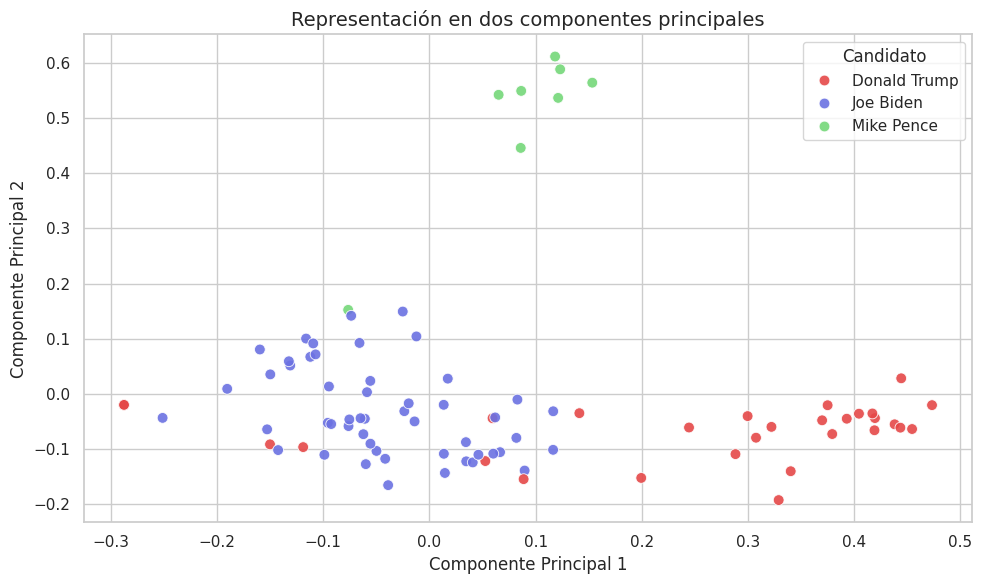

In [27]:
from sklearn.decomposition import PCA

# PCA a 2D
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_tfidf.toarray())

df_pca_2d = pd.DataFrame(X_train_pca_2d, columns=['PC1', 'PC2'])
df_pca_2d['speaker'] = train['speaker'].values

# Paleta personalizada
colors = {
    'Joe Biden': '#6b71e2',
    'Donald Trump': '#e54848',
    'Mike Pence': '#75d779'
}

# Gráfico
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(
    data=df_pca_2d,
    x='PC1',
    y='PC2',
    hue='speaker',
    palette=colors,
    s=60,
    alpha=0.9
)

plt.title('Representación en dos componentes principales', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Candidato')
plt.tight_layout()
plt.show()


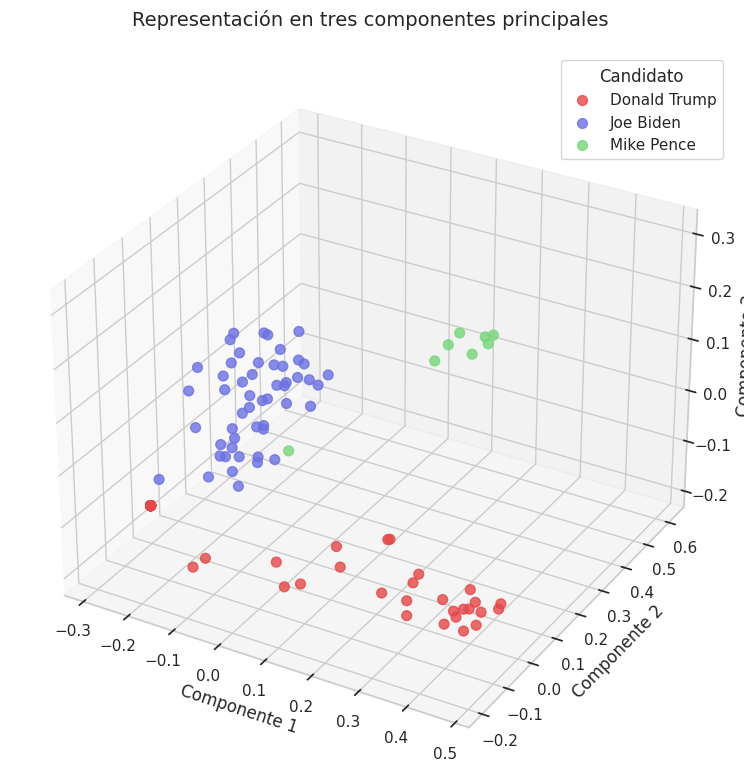

In [29]:
# Aplicar PCA con 3 componentes
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_tfidf.toarray())

# Crear DataFrame para graficar
df_pca_3d = pd.DataFrame(X_train_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['speaker'] = train['speaker'].values

# Visualización en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Colores personalizados para los candidatos
colors = {
    'Joe Biden': '#6b71e2',
    'Donald Trump': '#e54848',
    'Mike Pence': '#75d779'
}

for speaker in df_pca_3d['speaker'].unique():
    subset = df_pca_3d[df_pca_3d['speaker'] == speaker]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
               label=speaker, s=50, alpha=0.8, color=colors[speaker])

# Etiquetas y leyenda
ax.set_title('Representación en tres componentes principales', fontsize=14, pad=20)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.legend(title='Candidato')

plt.tight_layout()
plt.show()

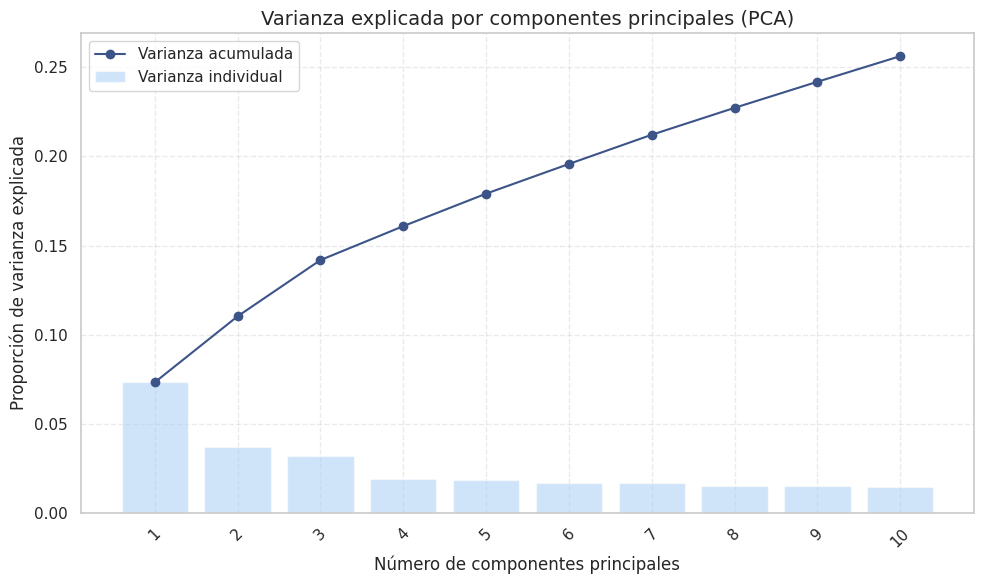

In [31]:
# Aplicar PCA
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_train_tfidf.toarray())

# Varianzas
varianza_explicada = pca_full.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Elegimos cuántos componentes mostrar (por ejemplo, los primeros 30)
max_componentes = min(10, len(varianza_explicada))

# Eje x
componentes = np.arange(1, max_componentes + 1)

# Gráfico
plt.figure(figsize=(10, 6))
plt.bar(componentes, varianza_explicada[:max_componentes], alpha=0.5, label='Varianza individual', color='#A1C9F4')
plt.plot(componentes, varianza_acumulada[:max_componentes], marker='o', color='#3C5488', label='Varianza acumulada')

plt.xticks(componentes, rotation=45)
plt.xlabel('Número de componentes principales', fontsize=12)
plt.ylabel('Proporción de varianza explicada', fontsize=12)
plt.title('Varianza explicada por componentes principales (PCA)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()



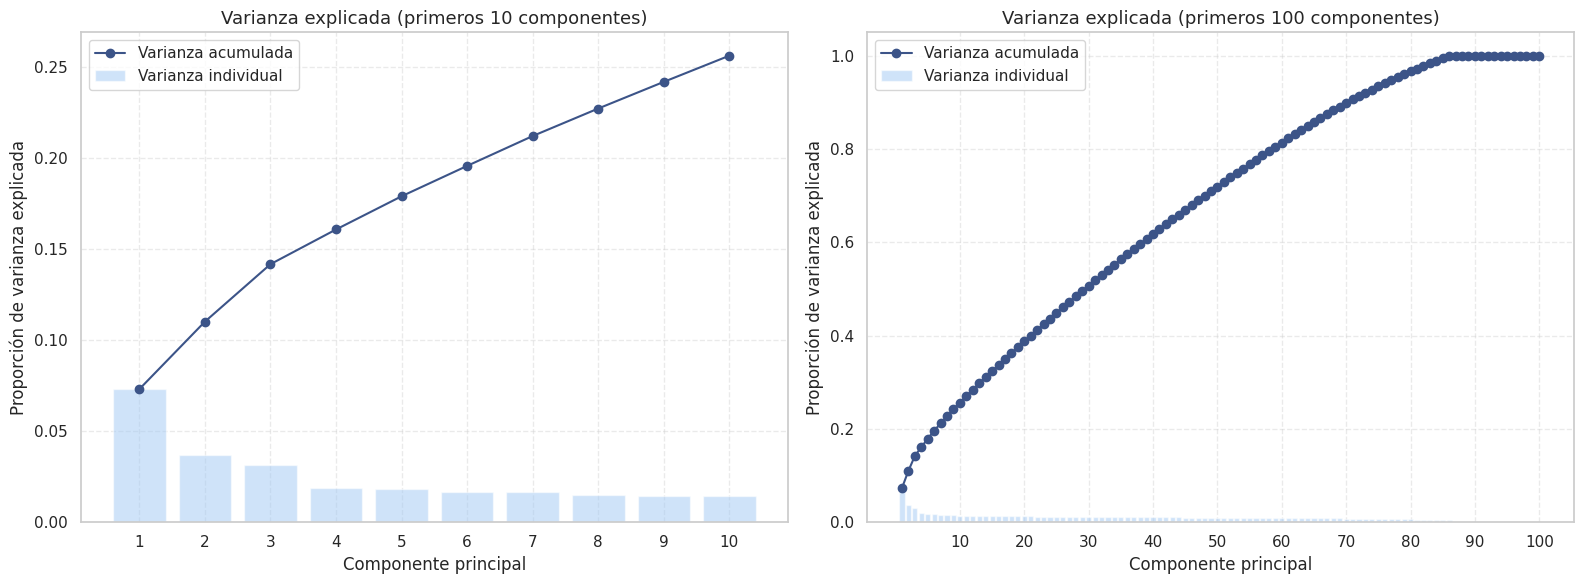

In [32]:
# PCA completo sobre la matriz TF-IDF de entrenamiento
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_train_tfidf.toarray())

# Varianzas explicadas
varianza_explicada = pca_full.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Configurar el gráfico con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SUBPLOT 1: primeros 10 componentes
componentes_10 = np.arange(1, 11)
axes[0].bar(componentes_10, varianza_explicada[:10], alpha=0.5, color='#A1C9F4', label='Varianza individual')
axes[0].plot(componentes_10, varianza_acumulada[:10], marker='o', color='#3C5488', label='Varianza acumulada')

axes[0].set_title('Varianza explicada (primeros 10 componentes)', fontsize=13)
axes[0].set_xlabel('Componente principal')
axes[0].set_ylabel('Proporción de varianza explicada')
axes[0].set_xticks(componentes_10)
axes[0].grid(True, linestyle='--', alpha=0.4)
axes[0].legend()

# SUBPLOT 2: primeros 100 componentes con xticks cada 10
componentes_100 = np.arange(1, 101)
xticks_cada_10 = np.arange(10, 101, 10)

axes[1].bar(componentes_100, varianza_explicada[:100], alpha=0.5, color='#A1C9F4', label='Varianza individual')
axes[1].plot(componentes_100, varianza_acumulada[:100], marker='o', color='#3C5488', label='Varianza acumulada')

axes[1].set_title('Varianza explicada (primeros 100 componentes)', fontsize=13)
axes[1].set_xlabel('Componente principal')
axes[1].set_ylabel('Proporción de varianza explicada')
axes[1].set_xticks(xticks_cada_10)
axes[1].grid(True, linestyle='--', alpha=0.4)
axes[1].legend()

# Ajustar diseño
plt.tight_layout()
plt.show()


**PARTE 2** - Entrenamiento y Evaluación de Modelos

Accuracy en test: 0.7447


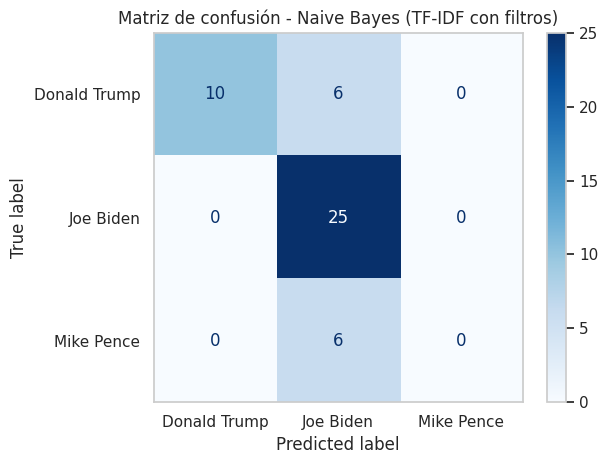

Reporte de clasificación:
              precision    recall  f1-score   support

Donald Trump      1.000     0.625     0.769        16
   Joe Biden      0.676     1.000     0.806        25
  Mike Pence      0.000     0.000     0.000         6

    accuracy                          0.745        47
   macro avg      0.559     0.542     0.525        47
weighted avg      0.700     0.745     0.691        47



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Entrenamiento del modelo
y_train = train['speaker']
y_test = test['speaker']

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predicción
y_pred = nb_model.predict(X_test_tfidf)

# Evaluación

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(cmap='Blues')
plt.grid(False)
plt.title("Matriz de confusión - Naive Bayes (TF-IDF con filtros)")
plt.tight_layout()
plt.show()

# Métricas detalladas
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))



 Resumen de validación cruzada (ordenado por performance):
 alpha  mean_accuracy  std_accuracy
 0.010       0.832900      0.054466
 0.100       0.767532      0.061974
 0.500       0.712987      0.050126
 1.000       0.694372      0.053926
 0.005       0.683983      0.088016
 2.000       0.575758      0.108474
 5.000       0.519048      0.031044


/tmp/ipython-input-36-2059196293.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipython-input-36-2059196293.py:36: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


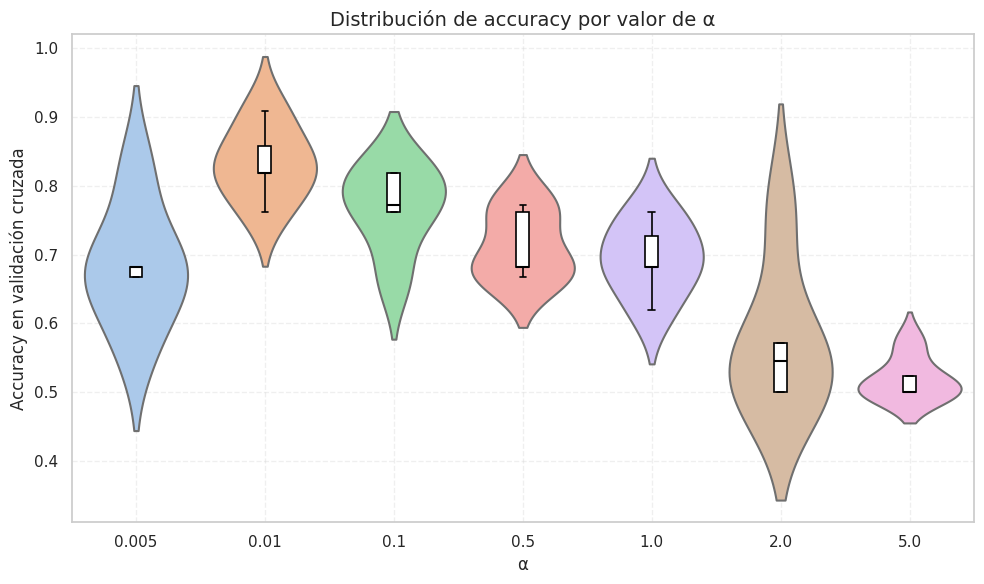

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB


# Lista de alphas a evaluar
alphas = [0.005, 0.01,0.1, 0.5, 1.0, 2.0, 5.0]

# Guardamos todos los resultados de CV
cv_data = []

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    for fold_score in scores:
        cv_data.append({'alpha': alpha, 'accuracy': fold_score})

# Convertir a DataFrame
df_cv = pd.DataFrame(cv_data)

# TABLA RESUMEN
summary = df_cv.groupby('alpha').agg(
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std')
).reset_index()

# Mostrar la tabla ordenada por mejor accuracy promedio
print("\n Resumen de validación cruzada (ordenado por performance):")
print(summary.sort_values(by='mean_accuracy', ascending=False).to_string(index=False))

# === Gráfico combinado: violín + boxplot ===
sns.set(style="whitegrid", context='notebook')
plt.figure(figsize=(10, 6))

# Violin plot (densidad)
sns.violinplot(
    x='alpha',
    y='accuracy',
    data=df_cv,
    inner=None,
    palette='pastel',
    scale='width',
    linewidth=1.5
)

# Boxplot encima
sns.boxplot(
    x='alpha',
    y='accuracy',
    data=df_cv,
    width=0.1,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.2),
    whiskerprops=dict(color='black', linewidth=1.2),
    capprops=dict(color='black', linewidth=1.2),
    medianprops=dict(color='black', linewidth=1.5),
    showfliers=False
)

# Etiquetas
plt.title('Distribución de accuracy por valor de α', fontsize=14)
plt.xlabel('α', fontsize=12)
plt.ylabel('Accuracy en validación cruzada', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


 Resultados de validación cruzada:
 alpha  mean_accuracy  std_accuracy
 0.015       0.841991      0.055184
 0.025       0.841991      0.055184
 0.020       0.841991      0.055184
 0.030       0.832900      0.054466
 0.010       0.832900      0.054466
 0.035       0.832900      0.054466
 0.040       0.823810      0.060945
 0.050       0.823810      0.060945
 0.045       0.823810      0.060945
 0.055       0.823810      0.060945
 0.060       0.814286      0.075112
 0.065       0.804762      0.071238
 0.070       0.795671      0.055830
 0.080       0.767532      0.061974
 0.075       0.767532      0.061974
 0.090       0.767532      0.061974
 0.085       0.767532      0.061974
 0.095       0.767532      0.061974
 0.005       0.683983      0.088016

 Mejor valor de alpha según CV: 0.015

 Accuracy en TEST con α = 0.015: 0.8511

 Reporte de clasificación:
              precision    recall  f1-score   support

Donald Trump      1.000     0.688     0.815        16
   Joe Biden      0.781     

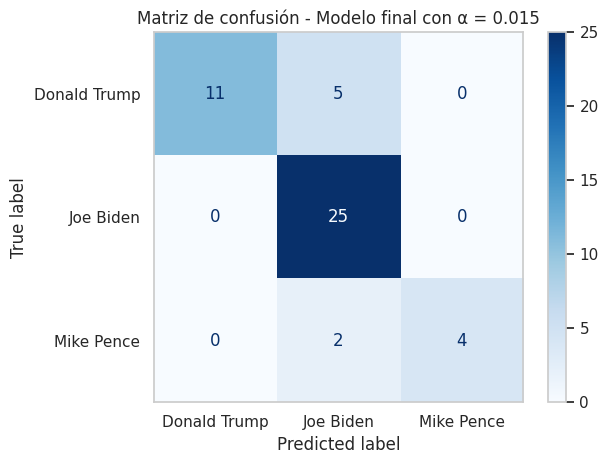

In [39]:
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

alphas = np.round(np.arange(0.005, 0.1, 0.005), 3)

# Validación cruzada para cada alpha
cv_data = []

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    for fold_score in scores:
        cv_data.append({'alpha': alpha, 'accuracy': fold_score})

# Crear resumen con mean y std
df_cv = pd.DataFrame(cv_data)
summary = df_cv.groupby('alpha').agg(
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std')
).reset_index()

print(" Resultados de validación cruzada:")
print(summary.sort_values(by='mean_accuracy', ascending=False).to_string(index=False))

# Seleccionar mejor alpha según mean_accuracy
best_alpha = summary.sort_values(by='mean_accuracy', ascending=False).iloc[0]['alpha']
print(f"\n Mejor valor de alpha según CV: {best_alpha}")

# Entrenar modelo final y evaluar sobre test
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train_tfidf, y_train)
y_pred_test = final_model.predict(X_test_tfidf)

# Métricas finales en test
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"\n Accuracy en TEST con α = {best_alpha}: {test_accuracy:.4f}")
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred_test, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.grid(False)
plt.title(f"Matriz de confusión - Modelo final con α = {best_alpha}")
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Accuracy en TEST - Regresión Logística: 0.8298

 Reporte de clasificación:
              precision    recall  f1-score   support

Donald Trump      1.000     0.688     0.815        16
   Joe Biden      0.758     1.000     0.862        25
  Mike Pence      1.000     0.500     0.667         6

    accuracy                          0.830        47
   macro avg      0.919     0.729     0.781        47
weighted avg      0.871     0.830     0.821        47



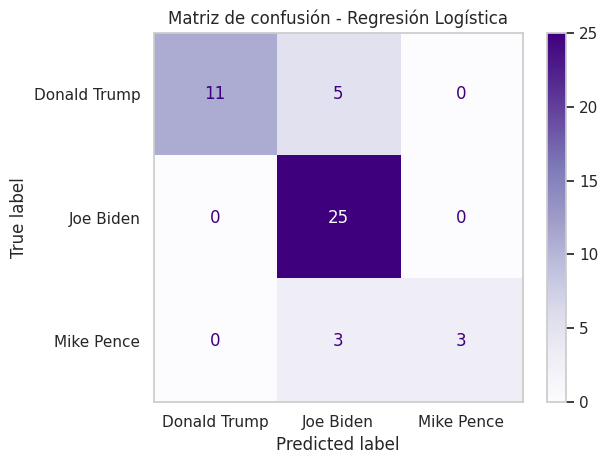

In [41]:

# Definir y entrenar el modelo
log_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42
)

log_model.fit(X_train_tfidf, y_train)


y_pred_log = log_model.predict(X_test_tfidf)

# Evaluar rendimiento
log_accuracy = accuracy_score(y_test, y_pred_log)
print(f" Accuracy en TEST - Regresión Logística: {log_accuracy:.4f}")

print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred_log, digits=3))

# Matriz de confusión
cm_log = confusion_matrix(y_test, y_pred_log, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_model.classes_)
disp.plot(cmap='Purples')
plt.grid(False)
plt.title("Matriz de confusión - Regresión Logística")
plt.tight_layout()
plt.show()


Cambiando dos candidatos que tengan pocos discursos

In [42]:
# Contar discursos por speaker
conteo_speakers = df_expandidos['speaker'].value_counts()

# Filtrar candidatos que tengan entre 6 y 14 discursos (excluyendo a Joe Biden)
candidatos_pocos = conteo_speakers[
    (conteo_speakers < 15) &
    (conteo_speakers > 3) &
    (conteo_speakers.index != 'Joe Biden')
]

candidatos_seleccionados = ['Joe Biden'] + list(candidatos_pocos.tail(2).index)
print("Candidatos seleccionados:", candidatos_seleccionados)

Candidatos seleccionados: ['Joe Biden', 'Elizabeth Warren', 'Barack Obama']


In [43]:
# Filtrar solo los discursos de los tres candidatos seleccionados
df_desbalance = df_expandidos[df_expandidos['speaker'].isin(candidatos_seleccionados)].copy()
# Aplicar limpieza y extracción del texto del orador
df_desbalance['clean_text'] = df_desbalance.apply(obtener_texto_filtrado, axis=1)


In [44]:
from sklearn.model_selection import train_test_split

# División estratificada
train_desb, test_desb = train_test_split(
    df_desbalance,
    test_size=0.3,
    stratify=df_desbalance['speaker'],
    random_state=42
)


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_desb = TfidfVectorizer(
    stop_words='english',
    use_idf=True,
    ngram_range=(1, 2)
)

# Ajustar solo con train
X_train_tfidf_desb = vectorizer_desb.fit_transform(train_desb['clean_text'])


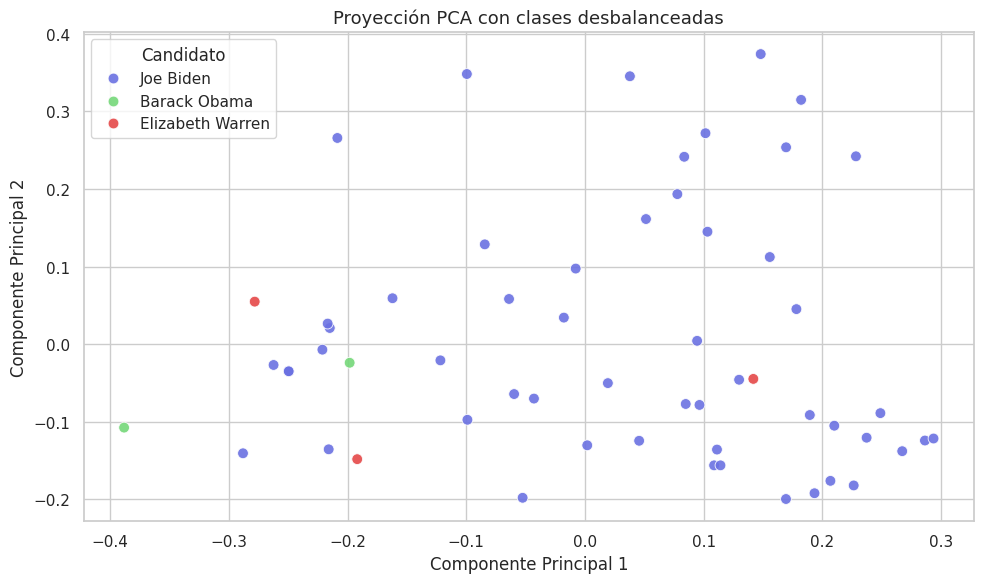

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# PCA 2D
pca_2d_desb = PCA(n_components=2)
X_pca_2d_desb = pca_2d_desb.fit_transform(X_train_tfidf_desb.toarray())

# Crear DataFrame para visualización
df_pca_2d_desb = pd.DataFrame(X_pca_2d_desb, columns=['PC1', 'PC2'])
df_pca_2d_desb['speaker'] = train_desb['speaker'].values

# Colores personalizados
paleta_colores = {
    'Joe Biden': '#6b71e2',
    candidatos_seleccionados[1]: '#e54848',
    candidatos_seleccionados[2]: '#75d779'
}

# Visualización
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(
    data=df_pca_2d_desb,
    x='PC1',
    y='PC2',
    hue='speaker',
    palette=paleta_colores,
    s=60,
    alpha=0.9
)

plt.title('Proyección PCA con clases desbalanceadas', fontsize=13)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Candidato')
plt.tight_layout()
plt.show()


In [47]:
from sklearn.decomposition import PCA
import pandas as pd

# PCA con 3 componentes
pca_3d_desb = PCA(n_components=3)
X_pca_3d_desb = pca_3d_desb.fit_transform(X_train_tfidf_desb.toarray())

# DataFrame para graficar
df_pca_3d_desb = pd.DataFrame(X_pca_3d_desb, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d_desb['speaker'] = train_desb['speaker'].values


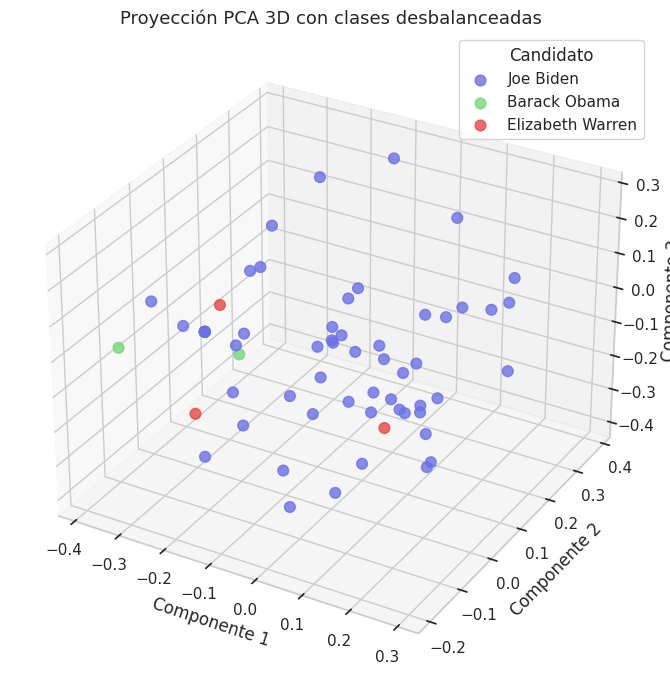

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for speaker in df_pca_3d_desb['speaker'].unique():
    subset = df_pca_3d_desb[df_pca_3d_desb['speaker'] == speaker]
    ax.scatter(
        subset['PC1'], subset['PC2'], subset['PC3'],
        label=speaker, s=60, alpha=0.8, color=paleta_colores[speaker]
    )

ax.set_title('Proyección PCA 3D con clases desbalanceadas', fontsize=13)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.legend(title='Candidato')
plt.tight_layout()
plt.show()


Reporte de clasificación:

                  precision    recall  f1-score   support

    Barack Obama       0.00      0.00      0.00         1
Elizabeth Warren       0.00      0.00      0.00         1
       Joe Biden       0.93      1.00      0.96        25

        accuracy                           0.93        27
       macro avg       0.31      0.33      0.32        27
    weighted avg       0.86      0.93      0.89        27

Accuracy del modelo Naive Bayes con clases desbalanceadas: 0.926


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


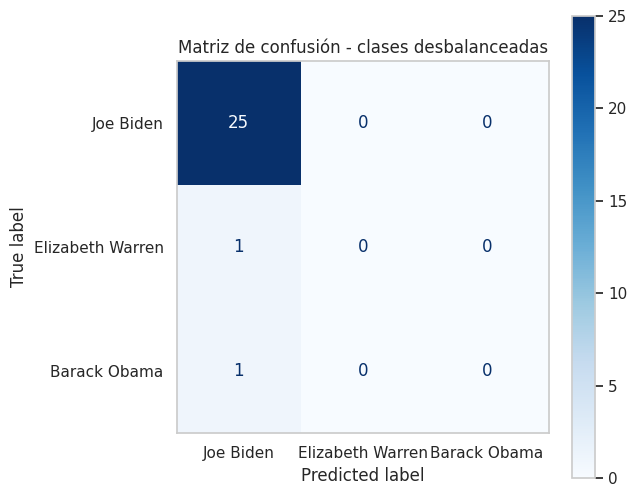

In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

X_test_tfidf_desb = vectorizer_desb.transform(test_desb['clean_text'])

# Entrenar modelo
modelo_desb = MultinomialNB()
modelo_desb.fit(X_train_tfidf_desb, train_desb['speaker'])


# Predecir sobre test
y_pred_desb = modelo_desb.predict(X_test_tfidf_desb)

# Reporte
print("Reporte de clasificación:\n")
print(classification_report(test_desb['speaker'], y_pred_desb))

# Calcular accuracy
accuracy_desb = accuracy_score(test_desb['speaker'], y_pred_desb)
print(f"Accuracy del modelo Naive Bayes con clases desbalanceadas: {accuracy_desb:.3f}")

# Matriz de confusión
matriz_conf_desb = confusion_matrix(test_desb['speaker'], y_pred_desb, labels=candidatos_seleccionados)

# Visualizar matriz
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_conf_desb, display_labels=candidatos_seleccionados)
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de confusión - clases desbalanceadas')
plt.show()
